# Convert units from CESM2 experiment output to forms read by NEMO

Variables available etc.: https://docs.google.com/spreadsheets/u/1/d/1OPcJsTcpaxBVZqcRpEEf16cipuL3CUk2nWojQ_ulRjE/edit?gid=0#gid=0

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cf
sys.path.append('/home/users/birgal/')
from nemo_python_git.file_io import find_cesm2_file
from nemo_python_git.forcing import cesm2_expt_all_atm_forcing, cesm2_expt_all_ocn_forcing
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.utils import fix_lon_range

In [2]:
ds = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_SALT_y1850.nc')

In [2]:
out_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
cesm2_expt_all_atm_forcing('LE2', ens_strs=['1011.001'], out_dir=out_dir, start_year=1850, end_year=1860)

Processing ensemble member 1011.001
Processing PRECS


In [2]:
out_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
cesm2_expt_all_ocn_forcing('LE2', ens_strs=['1011.001'], out_dir=out_dir, start_year=1850, end_year=1860)

Processing ensemble member 1011.001
Processing aice
Processing sithick
Processing sisnthick


In [3]:
nemoT = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test6/files/eANT025.L121_1m_19790101_19791231_grid_T.nc')

In [8]:
nemoT_ds = nemoT[['thetao','nav_lon_grid_T','nav_lat_grid_T']].rename({'x_grid_T':'x','y_grid_T':'y',
                                                                       'nav_lon_grid_T':'nav_lon','nav_lat_grid_T':'nav_lat'})
nemoT_ds = nemoT_ds.isel(time_counter=0)

#### Fill areas that are land in CESM2 but ocean in NEMO configuration with nearest ocean values

In [2]:
domcfg   = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc')
meshmask = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc')

In [3]:
climate_forcing = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
cesm2_temp = xr.open_dataset(f'{climate_forcing}CESM2-LE2_ens1011.001_TREFHT_y1850.nc')
cesm2_ocn  = xr.open_dataset(f'{climate_forcing}CESM2-LE2_ens1011.001_TEMP_y1850.nc')

In [94]:
start_cesm2 = cesm2_ocn.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70), z_t=slice(0,1))

In [79]:
nemo_mesh     = meshmask.isel(time_counter=0)
nemo_mesh_sub = meshmask.isel(time_counter=0, x=slice(500,800), y=slice(150,None), nav_lev=slice(0,1))
dummy_data    = np.zeros([nemo_mesh_sub.sizes['nav_lev'], nemo_mesh_sub.sizes['y'], nemo_mesh_sub.sizes['x']])
nemo_mesh_sub = nemo_mesh_sub.assign_coords({'z_t':start_cesm2_sub['z_t']}).drop_vars('nav_lev').rename({'z_t':'nav_lev'})

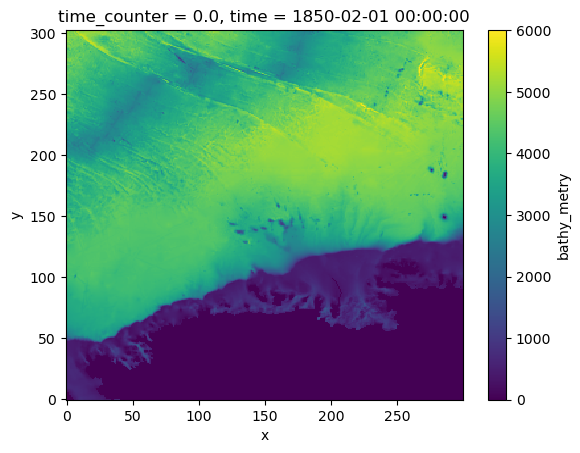

In [80]:
nemo_mesh_sub.bathy_metry.plot()

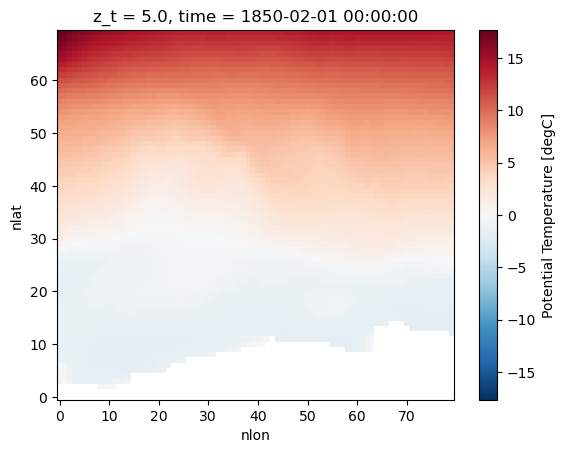

In [28]:
start_cesm2_sub.ConsTemp.isel(z_t=0).plot()

In [127]:
# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_2d (data, x, y, lon=None, lat=None, lon_bounds=None, lat_bounds=None):

    native_latlon = lon is None and lat is None
    print(native_latlon)

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    lon = convert_np(lon)
    lat = convert_np(lat)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()

    if native_latlon:
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'degrees_east'), properties={'axis':'X', 'standard_name':'longitude'})
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'degrees_north'), properties={'axis':'Y', 'standard_name':'latitude'})
        if lon_bounds is not None:
            dim_x.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        if lat_bounds is not None:
            dim_y.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
    else:
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'))
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'))
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')

    if not native_latlon:
        dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
        if lon_bounds is not None:
            dim_lon.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        field.set_construct(dim_lon, axes=('Y','X'))
        dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
        if lat_bounds is not None:
            dim_lat.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
        field.set_construct(dim_lat, axes=('Y','X'))
    field.set_data(cf.Data(data), axes=('Y', 'X'))
    return field

In [120]:
start_cesm2_sub['lon'] is None and start_cesm2_sub['lat'] is None

False

In [142]:
# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_2d3d (data, x, y, z, lon=None, lat=None, lon_bounds=None, lat_bounds=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    z = convert_np(z)
    lon = convert_np(lon)
    lat = convert_np(lat)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()

    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'), properties={'axis':'X'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'), properties={'axis':'Y'})
    dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'm'), properties={'axis':'Z'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    field.set_construct(cf.DomainAxis(size=z.size), key='Z')
    field.set_construct(dim_z, axes='Z')

    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
    # dim_dep = cf.AuxiliaryCoordinate(data=cf.Data(z, 'meters'), properties={'standard_name':'depth'})
    # field.set_construct(dim_dep, axes=('Z'))
        
    field.set_data(cf.Data(data), axes=('Z','Y','X'))
    return field

In [146]:
# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_3d2d (data, x, y, lon=None, lat=None, lon_bounds=None, lat_bounds=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    lon = convert_np(lon)
    lat = convert_np(lat)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()

    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'), properties={'axis':'X'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'), properties={'axis':'Y'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')

    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
        
    field.set_data(cf.Data(data), axes=('Y','X'))
    return field

In [81]:
def construct_cf_3d (data, x, y, z, lon=None, lat=None, depth=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    z = convert_np(z)
    lon = convert_np(lon)
    lat = convert_np(lat)
    depth = convert_np(depth)
    
    field = cf.Field()
    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'degrees_east'), properties={'axis':'X', 'standard_name':'longitude'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'degrees_north'), properties={'axis':'Y', 'standard_name':'latitude'})
    dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'meters'), properties={'axis':'Z', 'standard_name':'depth'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    field.set_construct(cf.DomainAxis(size=z.size), key='Z')
    field.set_construct(dim_z, axes='Z')
    
    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
    # dim_dep = cf.AuxiliaryCoordinate(data=cf.Data(depth, 'meters'), properties={'standard_name':'depth'})
    # field.set_construct(dim_dep, axes=('Z','Y','X'))

    field.set_data(cf.Data(data), axes=('Z', 'Y', 'X'))
    return field

In [144]:
dst_sub.dump()

-------
Field: 
-------

Data(axis=Z(10), axis=Y(303), axis=X(300)) = [[[1.0004666174809245, ..., 2.34306602403376]]]

Domain Axis: axis=X(300)
Domain Axis: axis=Y(303)
Domain Axis: axis=Z(10)

Dimension coordinate: axis=X
    axis = 'X'
    units = 'm'
    Data(axis=X(300)) = [0, ..., 299] m

Dimension coordinate: axis=Y
    axis = 'Y'
    units = 'm'
    Data(axis=Y(303)) = [0, ..., 302] m

Dimension coordinate: axis=Z
    axis = 'Z'
    units = 'm'
    Data(axis=Z(10)) = [0.4921427369117737, ..., 14.122696876525879] m

Auxiliary coordinate: longitude
    standard_name = 'longitude'
    units = 'degrees_east'
    Data(axis=Y(303), axis=X(300)) = [[-162.41943359375, ..., -87.25]] degrees_east

Auxiliary coordinate: latitude
    standard_name = 'latitude'
    units = 'degrees_north'
    Data(axis=Y(303), axis=X(300)) = [[-79.09760284423828, ..., -50.05917739868164]] degrees_north



In [ ]:
start_cesm2 = cesm2_ocn.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70))

nemo_mesh     = meshmask.isel(time_counter=0)
nemo_mesh_sub = meshmask.isel(time_counter=0, x=slice(500,800), y=slice(150,None))
dummy_data    = np.zeros([nemo_mesh_sub.sizes['nav_lev'], nemo_mesh_sub.sizes['y'], nemo_mesh_sub.sizes['x']])

src_sub = construct_cf_2d3d(start_cesm2_sub['ConsTemp'], start_cesm2_sub['nlon'], start_cesm2_sub['nlat'], start_cesm2_sub['z_t'],
                          lon=start_cesm2_sub['lon'], lat=start_cesm2_sub['lat'])
dst_sub = construct_cf_2d3d(nemo_mesh_sub['e3t_0'], nemo_mesh_sub['x'], nemo_mesh_sub['y'], nemo_mesh_sub['nav_lev'],
                          lon=nemo_mesh_sub['nav_lon'], lat=nemo_mesh_sub['nav_lat'])

src_regrid = src_sub.regrids(dst_sub, method='linear', src_z='Z', dst_z='Z', ln_z=False, 
                             dst_axes={'X':'X','Y':'Y','Z':'Z'}, src_axes={'X':'X','Y':'Y','Z':'Z'}, use_dst_mask=True,
                             src_cyclic=False, dst_cyclic=False)

ds = src_regrid.array

In [ ]:
ds.shape

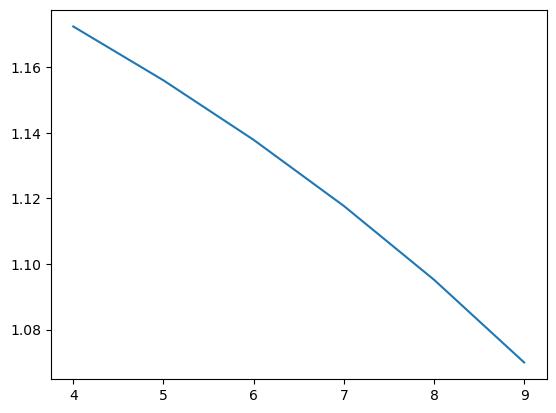

In [163]:
plt.plot(ds[:, 200, 200])

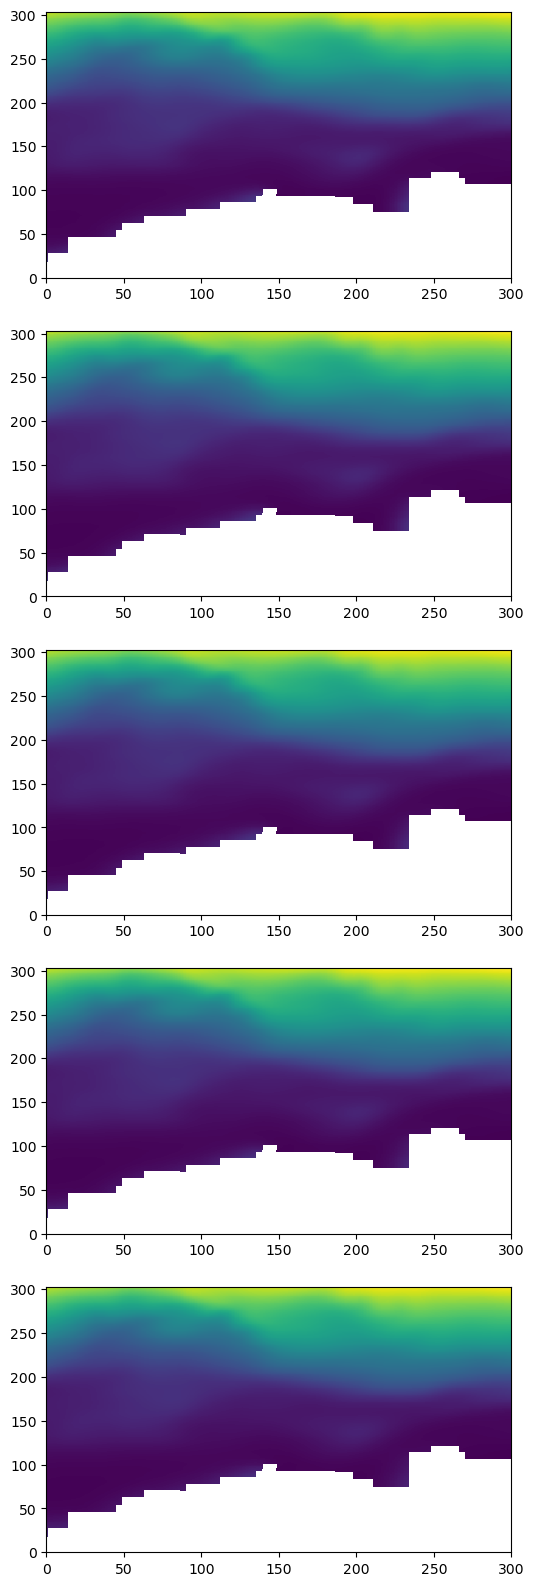

In [159]:
fig, ax = plt.subplots(5,1, figsize=(6,20))
for i in range(0,5):
    ax[i].pcolormesh(ds[i+5,:,:])


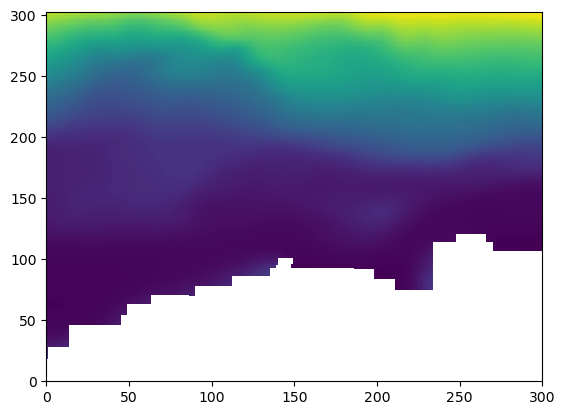

In [151]:
start_cesm2 = cesm2_ocn.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70), z_t=0)

nemo_mesh     = meshmask.isel(time_counter=0)
nemo_mesh_sub = meshmask.isel(time_counter=0, x=slice(500,800), y=slice(150,None), nav_lev=0)
dummy_data    = np.zeros([nemo_mesh_sub.sizes['y'], nemo_mesh_sub.sizes['x']])

src_sub = construct_cf_3d2d(start_cesm2_sub['ConsTemp'], start_cesm2_sub['nlon'], start_cesm2_sub['nlat'],
                          lon=start_cesm2_sub['lon'], lat=start_cesm2_sub['lat'])
dst_sub = construct_cf_3d2d(nemo_mesh_sub['e3t_0'], nemo_mesh_sub['x'], nemo_mesh_sub['y'],
                          lon=nemo_mesh_sub['nav_lon'], lat=nemo_mesh_sub['nav_lat'])

src_regrid = src_sub.regrids(dst_sub, method='linear',
                             dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'}, use_dst_mask=True,
                             src_cyclic=False, dst_cyclic=False)

ds = src_regrid.array
plt.pcolormesh(ds[:,:])

In [88]:
ds = src_regrid.array

In [89]:
src_regrid.dump()

-------
Field: 
-------

Data(depth(1), latitude(303), longitude(300)) = [[[nan, ..., --]]]

Domain Axis: depth(1)
Domain Axis: latitude(303)
Domain Axis: longitude(300)

Dimension coordinate: longitude
    axis = 'X'
    standard_name = 'longitude'
    units = 'degrees_east'
    Data(longitude(300)) = [0, ..., 299] degrees_east

Dimension coordinate: depth
    axis = 'Z'
    standard_name = 'depth'
    units = 'meters'
    Data(depth(1)) = [5.0] meters

Dimension coordinate: latitude
    axis = 'Y'
    standard_name = 'latitude'
    units = 'degrees_north'
    Data(latitude(303)) = [0, ..., 302] degrees_north

Auxiliary coordinate: longitude
    standard_name = 'longitude'
    units = 'degrees_east'
    Data(latitude(303), longitude(300)) = [[-162.41943359375, ..., -87.25]] degrees_east

Auxiliary coordinate: latitude
    standard_name = 'latitude'
    units = 'degrees_north'
    Data(latitude(303), longitude(300)) = [[-79.09760284423828, ..., -50.05917739868164]] degrees_north



In [46]:
print(start_cesm2_sub['z_t'].values[0:10])
print(nemo_mesh_sub['nav_lev'].values[0:10])

[ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]
[ 0.49214274  1.5264308   2.637745    3.8403995   5.1511426   6.5894766
  8.177981    9.942626   11.913038   14.122697  ]


In [90]:
print(src_regrid)
print(src_sub.array.shape)
print(dst_sub.array.shape)
print(ds.shape)

Field: 
-------
Data            : (depth(1), latitude(303), longitude(300))
Dimension coords: longitude(300) = [0, ..., 299] degrees_east
                : latitude(303) = [0, ..., 302] degrees_north
                : depth(1) = [5.0] meters
Auxiliary coords: longitude(latitude(303), longitude(300)) = [[-162.41943359375, ..., -87.25]] degrees_east
                : latitude(latitude(303), longitude(300)) = [[-79.09760284423828, ..., -50.05917739868164]] degrees_north
(1, 70, 80)
(1, 303, 300)
(1, 303, 300)


In [87]:
np.nanmin(ds[4,:,:])

np.float64(-1.8107003647515396)

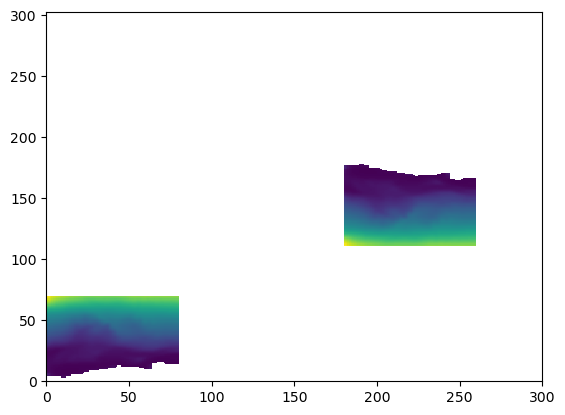

In [92]:
plt.pcolormesh(ds[0,:,:])

In [93]:
def construct_cf_2d (data, x, y, lon=None, lat=None):

    import cf
    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    lon = convert_np(lon)
    lat = convert_np(lat)
    
    field = cf.Field()
    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'degrees_east'), properties={'axis':'X', 'standard_name':'longitude'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'degrees_north'), properties={'axis':'Y', 'standard_name':'latitude'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    
    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))

    field.set_data(cf.Data(data), axes=('Y', 'X'))
    return field

In [51]:
cesm2_temp_interp = interp_latlon_cf(cesm2_temp.isel(time=0), meshmask.isel(time_counter=0), method='bilinear')

[  0.     1.25   2.5    3.75   5.     6.25   7.5    8.75  10.    11.25
  12.5   13.75  15.    16.25  17.5   18.75  20.    21.25  22.5   23.75
  25.    26.25  27.5   28.75  30.    31.25  32.5   33.75  35.    36.25
  37.5   38.75  40.    41.25  42.5   43.75  45.    46.25  47.5   48.75
  50.    51.25  52.5   53.75  55.    56.25  57.5   58.75  60.    61.25
  62.5   63.75  65.    66.25  67.5   68.75  70.    71.25  72.5   73.75
  75.    76.25  77.5   78.75  80.    81.25  82.5   83.75  85.    86.25
  87.5   88.75  90.    91.25  92.5   93.75  95.    96.25  97.5   98.75
 100.   101.25 102.5  103.75 105.   106.25 107.5  108.75 110.   111.25
 112.5  113.75 115.   116.25 117.5  118.75 120.   121.25 122.5  123.75
 125.   126.25 127.5  128.75 130.   131.25 132.5  133.75 135.   136.25
 137.5  138.75 140.   141.25 142.5  143.75 145.   146.25 147.5  148.75
 150.   151.25 152.5  153.75 155.   156.25 157.5  158.75 160.   161.25
 162.5  163.75 165.   166.25 167.5  168.75 170.   171.25 172.5  173.75
 175. 

In [48]:
def interp_latlondepth_cf (source, nemo, pster_src=False, periodic_src=False, periodic_nemo=True, method='conservative'):

    source.load()
    nemo.load()

    # Helper function to get an xarray DataArray of edges (size N+1, or N+1 by M+1) into a Numpy array of bounds for CF (size N x 2, or N x M x 4)
    def edges_to_bounds (edges):
        if len(edges.shape)==1:
            # 1D variable
            bounds = np.empty([edges.shape[0]-1, 2])
            bounds[...,0] = edges.values[:-1]
            bounds[...,1] = edges.values[1:]
        elif len(edges.shape)==2:
            # 2D variable
            bounds = np.empty([edges.shape[0]-1, edges.shape[1]-1, 4])
            bounds[...,0] = edges.values[:-1,:-1]  # SW corner
            bounds[...,1] = edges.values[:-1,1:] # SE
            bounds[...,2] = edges.values[1:,1:] # NE
            bounds[...,3] = edges.values[1:,:-1] # NW
        return bounds

    # Get source grid and data in CF format
    x_name = 'nlon'
    y_name = 'nlat'
    z_name = 'z_t'
    x_src = source['lon']
    y_src = source['lat']
    z_src = source['z_t']
    lon_src = None
    lat_src = None
    depth_src = None

    lon_bounds_src = None
    lat_bounds_src = None
    # Loop over data fields and convert each to CF
    data_cf = []
    for var in source:
        data_cf.append(construct_cf_3d(source[var], x_src, y_src, z_src, lon=lon_src, lat=lat_src, depth=depth_src, 
                                       lon_bounds=lon_bounds_src, lat_bounds=lat_bounds_src))
    # Get NEMO grid in CF format
    # Figure out some dimension and coordinate names
    if 'glamt' in nemo:
        # domain_cfg type
        x_name = 'x'
        y_name = 'y'
        z_name = 'nav_lev'
        lon_name = 'glamt'
        lat_name = 'gphit'
        depth_name = 'gdept_0'
    else:
        raise Exception('Unknown type of NEMO dataset.')

    dummy_data = np.zeros([nemo.sizes[z_name],nemo.sizes[y_name], nemo.sizes[x_name]])

    lon_bounds_nemo = None
    lat_bounds_nemo = None
    target_cf = construct_cf_3d(dummy_data, nemo[x_name], nemo[y_name], nemo[z_name], 
                                lon=nemo[lon_name], lat=nemo[lat_name], depth=nemo[depth_name], 
                                lon_bounds=lon_bounds_nemo, lat_bounds=lat_bounds_nemo)

    # Get weights with CF, using the first data field
    src_axes = None
    regrid_operator = data_cf[0].regrids(target_cf, src_cyclic=periodic_src, dst_cyclic=periodic_nemo, 
                                         src_z=z_src, dst_z=nemo[depth_name],
                                         src_axes=src_axes, dst_axes={'X':'X', 'Y':'Y'}, method=method, return_operator=True)

    # Now interpolate each field, re-using the weights each time, and add it to a new Dataset
    interp = xr.Dataset()
    for var, data_cf0 in zip(source, data_cf):
        print(var, data_cf0)
        data_interp = data_cf0.regrids(regrid_operator, src_axes=src_axes).array
        data_interp = xr.DataArray(data_interp, dims=['y', 'x'])
        interp = interp.assign({var:data_interp})

    return interp

# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_3d (data, x, y, z, lon=None, lat=None, depth=None, lon_bounds=None, lat_bounds=None):

    import cf
    native_latlon = lon is None and lat is None

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    z = convert_np(z)
    lon = convert_np(lon)
    lat = convert_np(lat)
    depth = convert_np(depth)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()
    if native_latlon:
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'degrees_east'), properties={'axis':'X', 'standard_name':'longitude'})
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'degrees_north'), properties={'axis':'Y', 'standard_name':'latitude'})
        dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'meters'), properties={'axis':'Z', 'standard_name':'depth'})
        if lon_bounds is not None:
            dim_x.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        if lat_bounds is not None:
            dim_y.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
    else:
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'))
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'))
        dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'm'))
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    field.set_construct(cf.DomainAxis(size=z.size), key='Z')
    field.set_construct(dim_z, axes='Z')
    if not native_latlon:
        dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
        if lon_bounds is not None:
            dim_lon.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        field.set_construct(dim_lon, axes=('Y','X'))
        dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
        if lat_bounds is not None:
            dim_lat.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
        dim_depth = cf.AuxiliaryCoordinate(data=cf.Data(depth, 'meters'), properties={'standard_name':'depth'})
        field.set_construct(dim_lat, axes=('Y','X'))
        field.set_construct(dim_depth, axes=('Z','Y','X'))
    field.set_data(cf.Data(data), axes=('Z', 'Y', 'X'))
    return field

In [50]:
def interp_latlon_cf (source, nemo, pster_src=False, periodic_src=False, periodic_nemo=True, method='conservative'):

    source.load()
    nemo.load()

    # Helper function to get an xarray DataArray of edges (size N+1, or N+1 by M+1) into a Numpy array of bounds for CF (size N x 2, or N x M x 4)
    def edges_to_bounds (edges):
        if len(edges.shape)==1:
            # 1D variable
            bounds = np.empty([edges.shape[0]-1, 2])
            bounds[...,0] = edges.values[:-1]
            bounds[...,1] = edges.values[1:]
        elif len(edges.shape)==2:
            # 2D variable
            bounds = np.empty([edges.shape[0]-1, edges.shape[1]-1, 4])
            bounds[...,0] = edges.values[:-1,:-1]  # SW corner
            bounds[...,1] = edges.values[:-1,1:] # SE
            bounds[...,2] = edges.values[1:,1:] # NE
            bounds[...,3] = edges.values[1:,:-1] # NW
        return bounds

    # Get source grid and data in CF format
    if pster_src:
        x_name = 'x'
        y_name = 'y'
        x_src = source['x']
        y_src = source['y']
        lon_src, lat_src = polar_stereo_inv(source['x'], source['y'])
    else:
        x_name = 'lon'
        y_name = 'lat'
        x_src = source['lon']
        y_src = source['lat']
        lon_src = None
        lat_src = None

    if method == 'conservative':
        if len(source[x_name].shape) != 1:
            raise Exception('Cannot find bounds if source dataset not a regular grid')
        # Get grid cell edges for x and y
        def construct_edges (array, dim):
            centres = 0.5*(array[:-1] + array[1:])
            if periodic_src and dim=='lon':
                first_edge = 0.5*(array[0] + array[-1] - 360)
                last_edge = 0.5*(array[0] + 360 + array[-1])
            else:
                first_edge = 2*array[0] - array[1]
                last_edge = 2*array[-1] - array[-2]
            edges = np.concatenate(([first_edge], centres, [last_edge]))
            return xr.DataArray(edges, coords={dim:edges})
        x_edges = construct_edges(source[x_name].values, x_name)
        y_edges = construct_edges(source[y_name].values, y_name)
        if pster_src:
            # Now convert to lat-lon
            lon_edges, lat_edges = polar_stereo_inv(x_edges, y_edges)
        else:
            lon_edges = x_edges
            lat_edges = y_edges
        lon_bounds_src = edges_to_bounds(lon_edges)
        lat_bounds_src = edges_to_bounds(lat_edges)
    else:
        lon_bounds_src = None
        lat_bounds_src = None
    # Loop over data fields and convert each to CF
    data_cf = []
    for var in source:
        data_cf.append(construct_cf(source[var], x_src, y_src, lon=lon_src, lat=lat_src, lon_bounds=lon_bounds_src, lat_bounds=lat_bounds_src))
    # Get NEMO grid in CF format
    # Figure out some dimension and coordinate names
    if 'glamt' in nemo:
        # domain_cfg type
        x_name = 'x'
        y_name = 'y'
        lon_name = 'glamt'
        lat_name = 'gphit'
    elif 'nav_lon_grid_T' in nemo:
        # model output type
        x_name = 'x_grid_T'
        y_name = 'y_grid_T'
        lon_name = 'nav_lon_grid_T'
        lat_name = 'nav_lat_grid_T'
    elif 'nav_lon' in nemo:
        # model output type NEMO 3.6
        x_name = 'x'
        y_name = 'y'
        lon_name = 'nav_lon'
        lat_name = 'nav_lat'
    else:
        raise Exception('Unknown type of NEMO dataset.')

    dummy_data = np.zeros([nemo.sizes[y_name], nemo.sizes[x_name]])
    if method == 'conservative':
        def construct_nemo_bounds (array):
            edges = extend_grid_edges(array, 'f', periodic=periodic_nemo)
            return edges_to_bounds(edges)
        if lon_name == 'glamt':
            lon_bounds_nemo = construct_nemo_bounds(nemo['glamf'])
            lat_bounds_nemo = construct_nemo_bounds(nemo['gphif'])
        elif lon_name == 'nav_lon_grid_T':
            lon_bounds_nemo = nemo['bounds_nav_lon_grid_T']
            lat_bounds_nemo = nemo['bounds_nav_lat_grid_T']
        elif lon_name == 'nav_lon':
            lon_bounds_nemo = nemo['bounds_lon']
            lat_bounds_nemo = nemo['bounds_lat']

    else:
        lon_bounds_nemo = None
        lat_bounds_nemo = None
    target_cf = construct_cf(dummy_data, nemo[x_name], nemo[y_name], lon=nemo[lon_name], lat=nemo[lat_name], lon_bounds=lon_bounds_nemo, lat_bounds=lat_bounds_nemo)

    # Get weights with CF, using the first data field
    if pster_src:
        src_axes = {'X':'X', 'Y':'Y'}
    else:
        src_axes = None
    regrid_operator = data_cf[0].regrids(target_cf, src_cyclic=periodic_src, dst_cyclic=periodic_nemo, src_axes=src_axes, dst_axes={'X':'X', 'Y':'Y'}, method=method, return_operator=True)

    # Now interpolate each field, re-using the weights each time, and add it to a new Dataset
    interp = xr.Dataset()
    for var, data_cf0 in zip(source, data_cf):
        print(var, data_cf0)
        data_interp = data_cf0.regrids(regrid_operator, src_axes=src_axes).array
        data_interp = xr.DataArray(data_interp, dims=['y', 'x'])
        interp = interp.assign({var:data_interp})

    return interp

# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf (data, x, y, lon=None, lat=None, lon_bounds=None, lat_bounds=None):

    import cf
    native_latlon = lon is None and lat is None

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    lon = convert_np(lon)
    lat = convert_np(lat)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()
    if native_latlon:
        print(x)
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'degrees_east'), properties={'axis':'X', 'standard_name':'longitude'})
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'degrees_north'), properties={'axis':'Y', 'standard_name':'latitude'})
        if lon_bounds is not None:
            dim_x.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        if lat_bounds is not None:
            dim_y.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
    else:
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'))
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'))
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    if not native_latlon:
        dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
        if lon_bounds is not None:
            dim_lon.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        field.set_construct(dim_lon, axes=('Y','X'))
        dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
        if lat_bounds is not None:
            dim_lat.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
        field.set_construct(dim_lat, axes=('Y','X'))
    field.set_data(cf.Data(data), axes=('Y', 'X'))
    return field

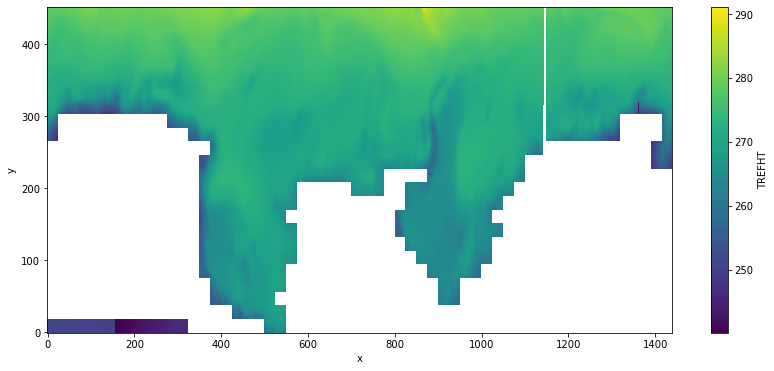

In [22]:
cesm2_temp_interp.TREFHT.plot(figsize=(14,6))

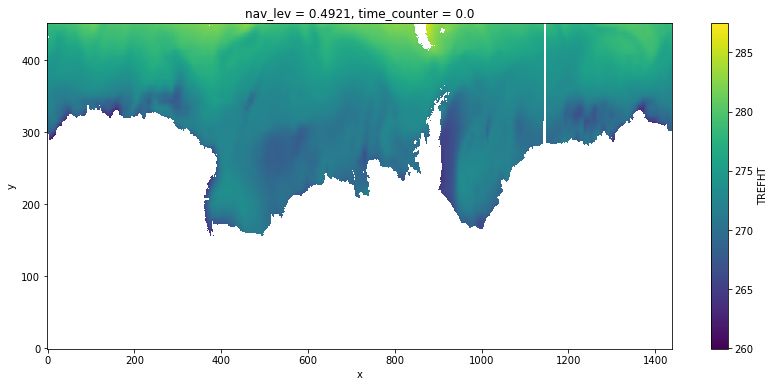

In [21]:
cesm2_temp_interp.TREFHT.where(meshmask.tmask.isel(time_counter=0, nav_lev=0)).plot(figsize=(14,6))

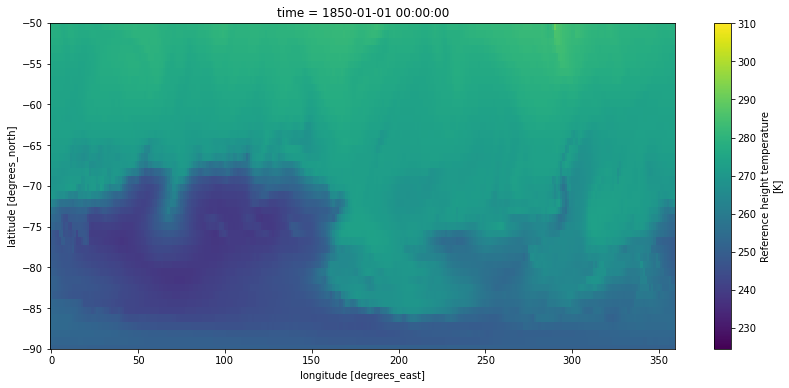

In [6]:
cesm2_temp.isel(time=0).TREFHT.plot(figsize=(14,6), ylim=(-90, -50))

In [ ]:
meshmask.tmask.isel(deptht=0).plot(figsize=(14,6))

In [ ]:
ocean_needs_to_be_filled = xr.where((meshmask.tmask == 0)*(cesm2_temp_interp.TREFHT), 1, 0)

In [17]:
cesm2_ocn.isel(time=0,z_t=0)

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320)
Coordinates:
    z_t       float32 500.0
    ULONG     (nlat, nlon) float64 ...
    ULAT      (nlat, nlon) float64 ...
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
    time      object 1850-02-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    ConsTemp  (nlat, nlon) float64 ...

In [ ]:
cesm2_ocn_interp  = interp_latlon_cf(cesm2_ocn.isel(time=0,z_t=0).rename({'TLAT':'lat','TLONG':'lon'}), nemoT_ds, method='bilinear')